# Initial Setup

In [12]:
import pandas as pd
filename = 'datasets/price_data_chicken.csv'

# Config for XGBoost and LSTM
df = pd.read_csv(filename)
LAG_LENGTH = round(len(df) * 0.15)
print(LAG_LENGTH)

# Specify sequence length for LSTM per product according to Table A.5 in the appendix of the thesis
SEQUENCE_LENGTH = 140

91


# ARIMA Model

In [13]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv(filename)

df_with_date = df.copy()

df_with_date = df_with_date.rename(columns={'Price': 'y'})

result_adf = adfuller(df_with_date['y'])
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])

if result_adf[1] > 0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

X_train, X_test, Y_train, Y_test = train_test_split(df_with_date['Date'], df_with_date['y'], test_size=0.15, random_state=None, shuffle=False)

train_idx = X_train.index
test_idx = X_test.index

train_dates = df_with_date.loc[train_idx, 'Date']
test_dates = df_with_date.loc[test_idx, 'Date']


model_arima = auto_arima(Y_train, seasonal=False)
model_arima.summary()
print(model_arima.get_params())
y_pred_test_arima = model_arima.predict(n_periods=len(Y_test))

# Uncomment for butter_price_DE dataset, as manual correction of the parameters was necessary and comment out the 4 lines above
# model_arima = ARIMA(Y_train, order=(2,2,2))
# model_arima = model_arima.fit()
# y_pred_test_arima = model_arima.forecast(steps=len(Y_test))

rmse_arima = root_mean_squared_error(Y_test, y_pred_test_arima)
mae_arima = mean_absolute_error(Y_test, y_pred_test_arima)
mape_arima = mape = mean_absolute_percentage_error(Y_test, y_pred_test_arima) * 100

print(f"\nForecast Metrics {filename}:")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAE: {mae_arima:.4f}")
print(f"MAPE: {mape_arima:.2f}%")

ADF Statistic: -4.994484
p-value: 0.000023
Series is stationary
{'maxiter': 50, 'method': 'lbfgs', 'order': (4, 0, 2), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}

Forecast Metrics datasets/price_data_chicken.csv:
RMSE: 0.7426
MAE: 0.6743
MAPE: 11.07%


# Prophet Model

In [14]:
import itertools
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

df = pd.read_csv(filename)

df = df.rename(columns={'Date': 'ds', 'Price': 'y'})

X = df['ds']
Y = df['y']
train_df, test_df = train_test_split(df, test_size=0.15, random_state=None, shuffle=False)

# Hyperparameter tuning implementation following Prophet documentation
# methodology for grid search and cross-validation
# Source: Taylor, S. J., & Letham, B. (n.d.). Diagnostics. Prophet.
#         https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
# Accessed: August 25, 2025
param_grid = {
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'holidays_prior_scale': [0.01, 1, 5, 10],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []


for params in all_params:
    m = Prophet(**params, seasonality_mode='additive')
    m.add_country_holidays('DE')
    m.fit(train_df)
    df_cv = cross_validation(m, pd.to_timedelta(96, unit='days'), parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])


tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

df = pd.read_csv(filename)
df = df.rename(columns={'Date': 'ds', 'Price': 'y'})

df['ds'] = pd.to_datetime(df['ds'])

train_df, test_df = train_test_split(df, test_size=0.15, random_state=None, shuffle=False)

m_tuned = Prophet(**best_params)
m_tuned.add_country_holidays('DE')
model_tuned = m_tuned.fit(train_df)
y_pred_test_prophet = model_tuned.predict(test_df)
y_pred_test_prophet = y_pred_test_prophet['yhat']
print(model_tuned.seasonalities)

rmse_prophet = root_mean_squared_error(test_df['y'], y_pred_test_prophet)
mae_prophet = mean_absolute_error(test_df['y'], y_pred_test_prophet)
mape_prophet = mape = mean_absolute_percentage_error(test_df['y'], y_pred_test_prophet) * 100

print(f"\nForecast Metrics {filename}:")
print(f"RMSE: {rmse_prophet:.4f}")
print(f"MAE: {mae_prophet:.4f}")
print(f"MAPE: {mape_prophet:.2f}%")

11:50:40 - cmdstanpy - INFO - Chain [1] start processing
11:50:40 - cmdstanpy - INFO - Chain [1] done processing
11:50:43 - cmdstanpy - INFO - Chain [1] start processing
11:50:43 - cmdstanpy - INFO - Chain [1] done processing
11:50:46 - cmdstanpy - INFO - Chain [1] start processing
11:50:46 - cmdstanpy - INFO - Chain [1] done processing
11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
11:50:50 - cmdstanpy - INFO - Chain [1] start processing
11:50:50 - cmdstanpy - INFO - Chain [1] done processing
11:50:53 - cmdstanpy - INFO - Chain [1] start processing
11:50:53 - cmdstanpy - INFO - Chain [1] done processing
11:50:55 - cmdstanpy - INFO - Chain [1] start processing
11:50:55 - cmdstanpy - INFO - Chain [1] done processing
11:50:57 - cmdstanpy - INFO - Chain [1] start processing
11:50:57 - cmdstanpy - INFO - Chain [1] done processing
11:51:00 - cmdstanpy - INFO - Chain [1] start processing
11:51:00 - cmdstanpy - INFO - Chain [1]

     seasonality_prior_scale  changepoint_prior_scale  holidays_prior_scale  \
0                       0.01                    0.001                  0.01   
1                       0.01                    0.001                  0.01   
2                       0.01                    0.001                  0.01   
3                       0.01                    0.001                  0.01   
4                       0.01                    0.001                  1.00   
..                       ...                      ...                   ...   
251                    10.00                    0.500                  5.00   
252                    10.00                    0.500                 10.00   
253                    10.00                    0.500                 10.00   
254                    10.00                    0.500                 10.00   
255                    10.00                    0.500                 10.00   

     changepoint_range      rmse  
0               

12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing


OrderedDict([('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 1.0, 'mode': 'additive', 'condition_name': None})])

Forecast Metrics datasets/price_data_chicken.csv:
RMSE: 0.7349
MAE: 0.7001
MAPE: 11.27%


# TBATS Model

Seasonal Periods [20.68, 22.47826086956522]


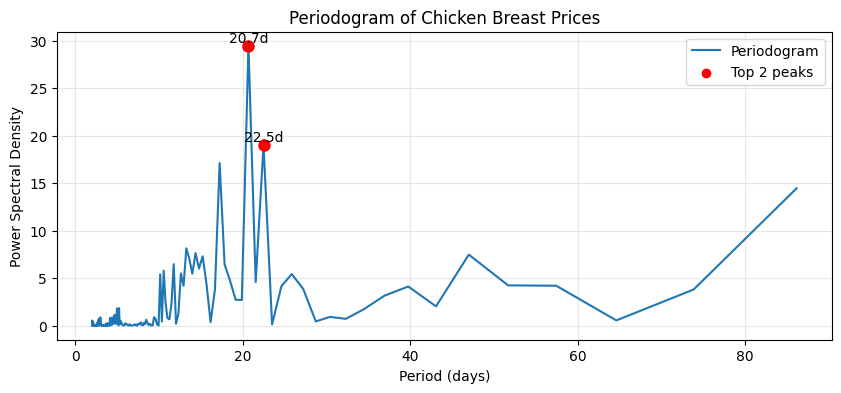


Forecast Metrics:
RMSE: 0.8971
MAE : 0.7414
MAPE: 12.27%


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tbats import TBATS
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from scipy.signal import periodogram, find_peaks
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv(filename)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

train, test = train_test_split(
    df, test_size=0.15, random_state=None, shuffle=False
)

freqs, power = periodogram(train["Price"], fs=1.0)

periods = 1 / freqs[1:]  # skip DC component
power = power[1:]

peaks, _ = find_peaks(power, height=np.median(power) * 2)

n_peaks = 2
top_idx = peaks[np.argsort(power[peaks])[-n_peaks:]]
top_idx = top_idx[np.argsort(periods[top_idx])]  # optional: ascending order
seasonal_periods = periods[top_idx].tolist()
print(f"Seasonal Periods", seasonal_periods)

plt.figure(figsize=(10, 4))
mask = periods <= 100
plt.plot(periods[mask], power[mask], label="Periodogram")
for peak in top_idx:
    if periods[peak] <= 100:
        plt.plot(periods[peak], power[peak], "ro", markersize=8)
        plt.text(
            periods[peak],
            power[peak],
            f"{periods[peak]:.1f}d",
            ha="center",
            va="bottom",
        )
plt.scatter([], [], color='red', label=f"Top {n_peaks} peaks")
plt.xlabel("Period (days)")
plt.ylabel("Power Spectral Density")
plt.title("Periodogram of Chicken Breast Prices")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

model = TBATS(seasonal_periods=seasonal_periods, use_trend=True)
fitted_model = model.fit(train)

y_pred_test_tbats = fitted_model.forecast(len(test))

rmse_tbats = root_mean_squared_error(test["Price"], y_pred_test_tbats)
mae_tbats = mean_absolute_error(test["Price"], y_pred_test_tbats)
mape_tbats = mean_absolute_percentage_error(test["Price"], y_pred_test_tbats) * 100

print("\nForecast Metrics:")
print(f"RMSE: {rmse_tbats:.4f}")
print(f"MAE : {mae_tbats:.4f}")
print(f"MAPE: {mape_tbats:.2f}%")

# XGBoost Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import wandb
import holidays

df = pd.read_csv(filename)

df['Date'] = pd.to_datetime(df['Date'])
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['dayofmonth'] = df['Date'].dt.day
df['dayofyear'] = df['Date'].dt.day_of_year
df['quarter'] = df['Date'].dt.quarter
df['weekofmonth'] = (df['dayofmonth'] - 1) // 7 + 1
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df = df.sort_values('Date')

df['price_lag1'] = df['Price'].shift(LAG_LENGTH)

german_holidays = holidays.Germany()
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x.date() in german_holidays else 0)

# 1. Days until next holiday (captures pre-holiday shopping surge)
def days_until_next_holiday(date, holidays_dict):
    future_holidays = [h for h in holidays_dict if h > date.date()]
    if future_holidays:
        return (min(future_holidays) - date.date()).days
    return 365  # If no holidays found in next year

# Create holiday features
df['days_until_holiday'] = df['Date'].apply(lambda x: days_until_next_holiday(x, german_holidays))

# Pre-holiday period (1-3 days before holiday - shopping surge)
df['is_pre_holiday'] = (df['days_until_holiday'] <= 3).astype(int)

df_with_date = df.copy()
X = df.drop(columns=['Price', 'Date'])
Y = df['Price']

# 0.7 worked well for chicken
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=None, shuffle=False)

train_idx = X_train.index
test_idx = X_test.index
train_dates = df_with_date.loc[train_idx, 'Date']
test_dates = df_with_date.loc[test_idx, 'Date']

# Parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 7, 9],
    'n_estimators': [50, 100, 200, 300, 500],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0],
    'gamma': [0, 0.0001, 0.001, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7],
}

model_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
)

grid_search = RandomizedSearchCV(
    estimator=model_tuned,
    param_distributions=param_grid,
    n_iter=200,
    cv=20,
    n_jobs=-1,
    scoring='neg_mean_squared_error', 
    verbose=1,
    random_state=42
)

print("Starting hyperparameter search...")
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {best_params}")

final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=10,
    tree_method    = "hist", 
    **best_params
)

print("Training final model with best parameters...")
final_model.fit(
    X_train, Y_train, 
    eval_set=[(X_train, Y_train), (X_test, Y_test)],
    verbose=False
)


best_iteration = final_model.best_iteration
print(f"Best iteration: {best_iteration}")
print(f"Total iterations trained: {final_model.n_estimators}")

y_pred_test_xgboost = final_model.predict(X_test)

rmse_xgboost = root_mean_squared_error(Y_test, y_pred_test_xgboost)
mae_xgboost = mean_absolute_error(Y_test, y_pred_test_xgboost)
mape_xgboost = mean_absolute_percentage_error(Y_test, y_pred_test_xgboost) * 100

print('Test RMSE:', rmse_xgboost)
print('Test MAE:', mae_xgboost)
print('Test MAPE:', f"{mape_xgboost:.2f}%")

param_keys = ['subsample', 'n_estimators', 'min_child_weight', 'max_depth', 'learning_rate', 'gamma', 'colsample_bytree']
best_params_ordered = {key: final_model.get_params()[key] for key in param_keys}
print("Best model parameters:", best_params_ordered)

Starting hyperparameter search...
Fitting 20 folds for each of 200 candidates, totalling 4000 fits
Best score: -0.576
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.3}
Training final model with best parameters...
Best iteration: 6
Total iterations trained: 100
Test RMSE: 0.7250996168207885
Test MAE: 0.6722001473799998
Test MAPE: 10.99%
Best model parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.3}


# LSTM Model

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import keras_tuner as kt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import holidays
import os

np.random.seed(1234)
tf.random.set_seed(1234)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(1)
tf.keras.utils.set_random_seed(1)

df = pd.read_csv(filename)
df['Date'] = pd.to_datetime(df['Date'])
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['dayofmonth'] = df['Date'].dt.day
df['dayofyear'] = df['Date'].dt.day_of_year
df['quarter'] = df['Date'].dt.quarter
df['weekofmonth'] = (df['dayofmonth'] - 1) // 7 + 1
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

df = df.sort_values('Date')

german_holidays_dict = holidays.Germany(years=df['Date'].dt.year.unique())
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x.date() in german_holidays_dict else 0)

df = df.dropna()

# Split data
X = df.drop(columns=['Date', 'Price'])
Y = df['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=None, shuffle=False)

# Get dates for plotting
train_dates = df.loc[X_train.index, 'Date']
test_dates = df.loc[X_test.index, 'Date']

SEQUENCE_LENGTH = SEQUENCE_LENGTH
N_TEST_PERIODS = len(X_test)

print(f"Training: {train_dates.min()} to {train_dates.max()} ({len(X_train)} periods)")
print(f"Testing: {test_dates.min()} to {test_dates.max()} ({len(X_test)} periods)")
print(f"Sequence length: {SEQUENCE_LENGTH}, Test periods: {N_TEST_PERIODS}")
print(len(X_test))

def create_multi_output_sequences(X_data, Y_data, sequence_length, forecast_days):
    X_seq, Y_seq = [], []
    for i in range(sequence_length, len(X_data) - forecast_days + 1):
        
        X_seq.append(X_data.iloc[i-sequence_length:i].values)
        
        Y_seq.append(Y_data.iloc[i:i+forecast_days].values)
    return np.array(X_seq), np.array(Y_seq)


X_train_seq, Y_train_seq = create_multi_output_sequences(X_train, Y_train, SEQUENCE_LENGTH, N_TEST_PERIODS)

X_test_seq = X_train.iloc[-SEQUENCE_LENGTH:].values.reshape(1, SEQUENCE_LENGTH, -1)
Y_test_actual = Y_test.values

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training targets shape: {Y_train_seq.shape}")
print(f"Test sequence shape: {X_test_seq.shape}")
print(f"Test targets shape: {Y_test_actual.shape}")

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_Y = MinMaxScaler(feature_range=(0,1))

X_train_reshaped = X_train_seq.reshape(-1, X_train_seq.shape[-1])
Y_train_reshaped = Y_train_seq.reshape(-1, 1)

X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train_seq.shape)
Y_train_scaled = scaler_Y.fit_transform(Y_train_reshaped).reshape(Y_train_seq.shape)

X_test_scaled = scaler_X.transform(X_test_seq.reshape(-1, X_test_seq.shape[-1])).reshape(X_test_seq.shape)

print(f"Scaled training X shape: {X_train_scaled.shape}")
print(f"Scaled training Y shape: {Y_train_scaled.shape}")
print(f"Scaled test X shape: {X_test_scaled.shape}")

def build_model(hp):
    model = Sequential()
    
    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

    n_layers = hp.Int('n_layers', min_value=1, max_value=3, step=1)
    for i in range(n_layers):
        return_sequences = (i < n_layers - 1)
        model.add(LSTM(
            hp.Int(f'lstm_{i}_units', min_value=32, max_value=128, step=16),
            return_sequences=return_sequences,
            recurrent_dropout=hp.Float(f'recurrent_dropout_{i}', 0.0, 0.3, step=0.1)
        ))
    
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.4, step=0.1)))
    model.add(Dense(units=N_TEST_PERIODS))
    
    model.compile(
        loss='mean_squared_error', 
        metrics=['mse'],
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.01
        )
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=12,
    seed=42
)

tuner.search(
    X_train_scaled,
    Y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"Number of layers: {best_hps.get('n_layers')}")
for i in range(best_hps.get('n_layers')):
    print(f"LSTM {i+1} units: {best_hps.get(f'lstm_{i}_units')}")
    print(f"LSTM {i+1} recurrent_dropout: {best_hps.get(f'recurrent_dropout_{i}')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")

print('Training final model with best params...')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

best_model.fit(
    X_train_scaled,
    Y_train_scaled,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    callbacks=[es]
)

model = best_model
model.summary()

print('Final model ready for rolling predictions')

Y_pred_scaled = model.predict(X_test_scaled)
y_pred_test_lstm = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).reshape(Y_pred_scaled.shape).flatten()

print("=" * 60)
print("FINAL MODEL HYPERPARAMETERS (After Tuning)")
print("=" * 60)
print(f"Number of LSTM layers: {best_hps.get('n_layers')}")
for i in range(best_hps.get('n_layers')):
    print(f"LSTM Layer {i+1}:")
    print(f"  - Units: {best_hps.get(f'lstm_{i}_units')}")
    print(f"  - Recurrent Dropout: {best_hps.get(f'recurrent_dropout_{i}')}")
print(f"Final Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Sequence Length: {SEQUENCE_LENGTH}")
print(f"Prediction Periods: {N_TEST_PERIODS}")
print("=" * 60)
print()

rmse_lstm = root_mean_squared_error(Y_test_actual, y_pred_test_lstm)
mae_lstm = mean_absolute_error(Y_test_actual, y_pred_test_lstm)
mape_lstm = mape = mean_absolute_percentage_error(Y_test_actual, y_pred_test_lstm) * 100

print(f"\nForecast Metrics:")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"MAPE: {mape_lstm:.2f}%")


Trial 12 Complete [00h 01m 49s]
val_mse: 0.11390101164579391

Best val_mse So Far: 0.11193227767944336
Total elapsed time: 00h 11m 09s
Best hyperparameters:
Number of layers: 2
LSTM 1 units: 32
LSTM 1 recurrent_dropout: 0.1
LSTM 2 units: 32
LSTM 2 recurrent_dropout: 0.0
Dropout rate: 0.1
Training final model with best params...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.1307 - mse: 0.1307 - val_loss: 0.1163 - val_mse: 0.1163
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1273 - mse: 0.1273 - val_loss: 0.1135 - val_mse: 0.1135
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1226 - mse: 0.1226 - val_loss: 0.1140 - val_mse: 0.1140
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1190 - mse: 0.1190 - val_loss: 0.1166 - val_mse: 0.1166
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1174 - mse: 0.1174 - val_loss: 0.1182 - val_mse: 0.1182
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1141 - mse: 0.1141 - val_loss

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 140, 32)        │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 92)             │         3,036 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,814 (194.59 KB)

 Trainable params: 16,604 (64.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,210 (129.73 KB)

Final model ready for rolling predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
FINAL MODEL HYPERPARAMETERS (After Tuning)
Number of LSTM layers: 2
LSTM Layer 1:
  - Units: 32
  - Recurrent Dropout: 0.1
LSTM Layer 2:
  - Units: 32
  - Recurrent Dropout: 0.0
Final Dropout Rate: 0.1
Sequence Length: 140
Prediction Periods: 92


Forecast Metrics:
RMSE: 0.8047
MAE: 0.6663
MAPE: 10.74%


# Create Final Figure

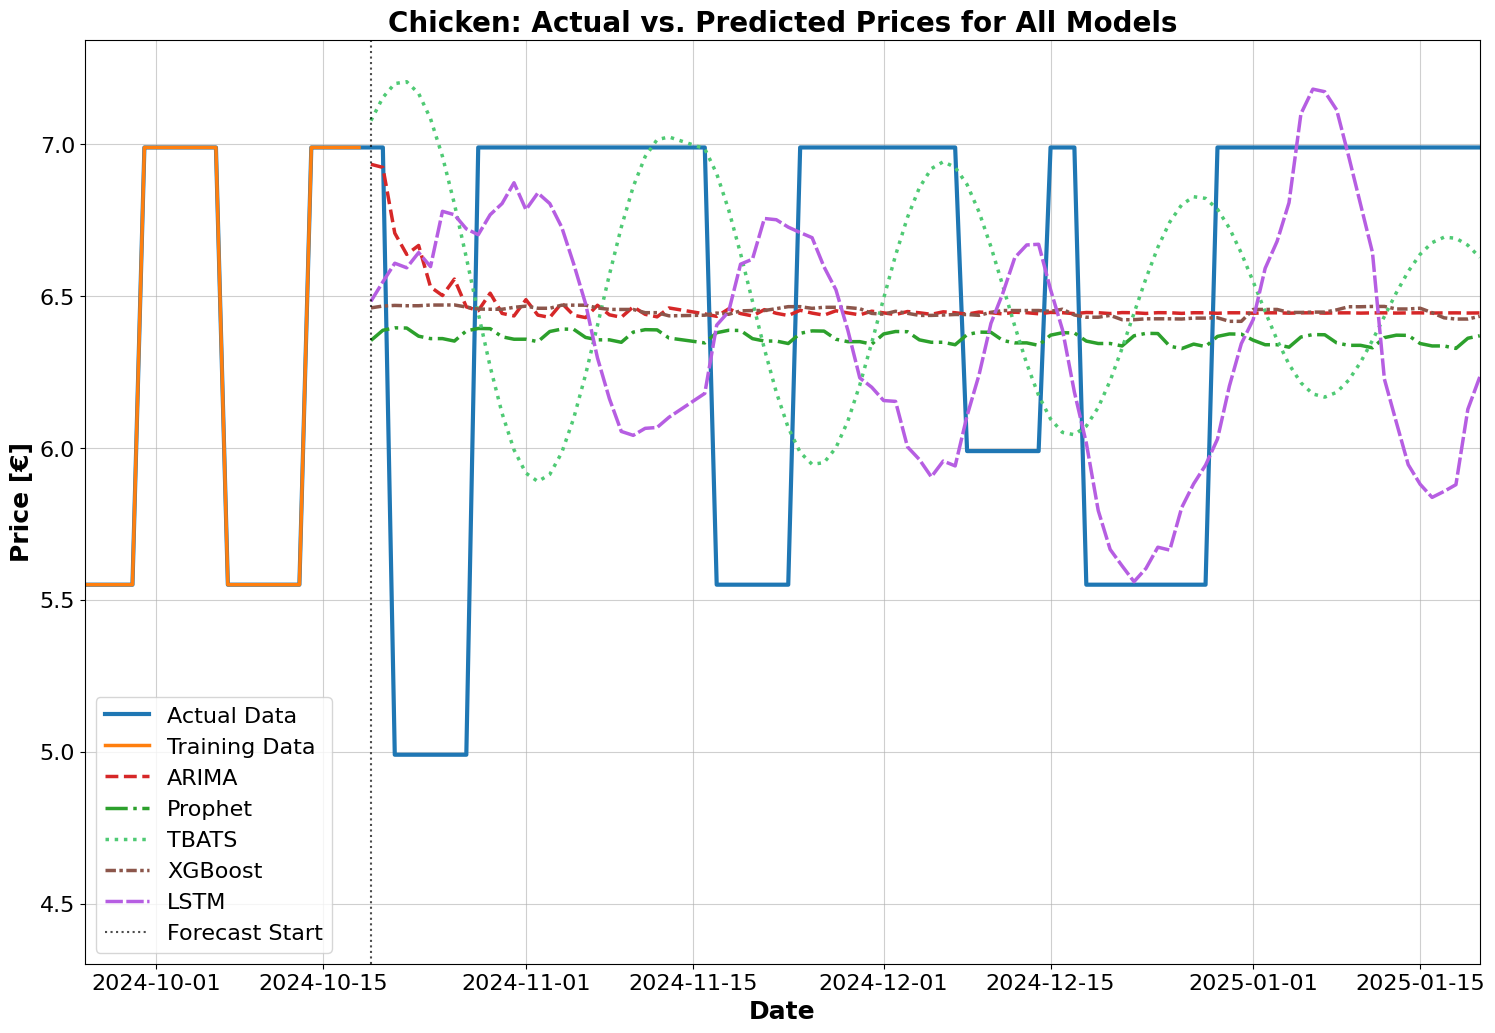

In [21]:
import os
import matplotlib.pyplot as plt

base = os.path.basename(filename)
product_raw = base.replace('price_data_', '').replace('.csv', '')
product_name = product_raw.capitalize()
df_plot = pd.read_csv(filename)
fig1, ax = plt.subplots(figsize=(18,12))
plt.subplot()
plt.plot(pd.to_datetime(df_plot['Date']), df_plot['Price'], label='Actual Data', color='#1f77b4', linewidth=3)
plt.plot(pd.to_datetime(train_dates), Y_train, color='#ff7f0e', label='Training Data', linewidth=2.5)
plt.plot(pd.to_datetime(test_dates), y_pred_test_arima, color='#d62728', linestyle='--', label='ARIMA', linewidth=2.5)
plt.plot(pd.to_datetime(test_dates), y_pred_test_prophet, color='#2ca02c', linestyle='-.', label='Prophet', linewidth=2.5)
plt.plot(pd.to_datetime(test_dates), y_pred_test_tbats, color='#4fca74', linestyle=':', label='TBATS', linewidth=2.5)
plt.plot(pd.to_datetime(test_dates), y_pred_test_xgboost, color='#8c564b', linestyle=(0, (3, 1, 1, 1)), label='XGBoost', linewidth=2.5)
plt.plot(pd.to_datetime(test_dates), y_pred_test_lstm, color="#b65ee2", linestyle=(0, (5, 1)), label='LSTM', linewidth=2.5)
plt.axvline(x=pd.to_datetime(test_dates.iloc[0]),
            color='black', linestyle=':', alpha=0.7, label='Forecast Start')
ax.set_xbound(
    lower=train_dates.iloc[-24],
    upper=test_dates.iloc[-1]
)
plt.title(f'{product_name}: Actual vs. Predicted Prices for All Models', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Price [€]', fontsize=18, fontweight='bold')
plt.legend(fontsize=16, loc="lower left")
plt.grid(True, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=16)